**Importing Libraries**


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import time
import matplotlib.pyplot as plt
import seaborn as sns

**Mounting the Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Loading the Dataset**

In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/Indian_earthquake_data.csv'

df = pd.read_csv(file_path)
print(df.head())


               Origin Time  Latitude  Longitude  Depth  Magnitude  \
0  2021-07-31 09:43:23 IST     29.06      77.42    5.0        2.5   
1  2021-07-30 23:04:57 IST     19.93      72.92    5.0        2.4   
2  2021-07-30 21:31:10 IST     31.50      74.37   33.0        3.4   
3  2021-07-30 13:56:31 IST     28.34      76.23    5.0        3.1   
4  2021-07-30 07:19:38 IST     27.09      89.97   10.0        2.1   

                               Location  
0          53km NNE of New Delhi, India  
1  91km W of Nashik, Maharashtra, India  
2   49km WSW of Amritsar, Punjab, India  
3           50km SW of Jhajjar, Haryana  
4            53km SE of Thimphu, Bhutan  


**Preprocessing, Featue engineering and Model Training**

In [ ]:
# Preprocessing
# Convert Origin Time
df['Origin Time'] = pd.to_datetime(df['Origin Time'], errors='coerce')
df.dropna(subset=['Origin Time'], inplace=True)


/tmp/ipython-input-4-1147160445.py:3: FutureWarning: Parsed string "2021-07-31 09:43:23 IST" included an un-recognized timezone "IST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['Origin Time'] = pd.to_datetime(df['Origin Time'], errors='coerce')


In [ ]:
# Feature Engineering
df['Hour'] = df['Origin Time'].dt.hour
df['Day_of_Week'] = df['Origin Time'].dt.day_name()

In [ ]:
# Label target class based on Magnitude
def label_severity(mag):
    if mag < 3:
        return 'Low'
    elif 3 <= mag < 5:
        return 'Moderate'
    else:
        return 'Severe'

df['Severity'] = df['Magnitude'].apply(label_severity)


In [ ]:
# Encode categorical features
le = LabelEncoder()
df['Day_of_Week_Encoded'] = le.fit_transform(df['Day_of_Week'])


In [ ]:
# Features and Target
features = ['Latitude', 'Longitude', 'Depth', 'Hour', 'Day_of_Week_Encoded']
X = df[features]
y = df['Severity']

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Class distribution after SMOTE:
Severity
Moderate    1692
Low         1692
Severe      1692
Name: count, dtype: int64


In [ ]:
# Train Parallel Model
model_parallel = RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight='balanced', random_state=42)
start_parallel = time.time()
model_parallel.fit(X_train_resampled, y_train_resampled)
end_parallel = time.time()
y_pred_parallel = model_parallel.predict(X_test)


In [ ]:
# Train Serial Model
model_serial = RandomForestClassifier(n_estimators=100, n_jobs=1, class_weight='balanced', random_state=42)
start_serial = time.time()
model_serial.fit(X_train_resampled, y_train_resampled)
end_serial = time.time()
y_pred_serial = model_serial.predict(X_test)


In [ ]:
# Evaluation
print("\n--- Evaluation After SMOTE + Class Weights ---")
print("Parallel Training Time:", round(end_parallel - start_parallel, 4), "seconds")
print("Serial Training Time:", round(end_serial - start_serial, 4), "seconds")
print("\nParallel Model Classification Report:\n", classification_report(y_test, y_pred_parallel))
print("Serial Model Classification Report:\n", classification_report(y_test, y_pred_serial))



--- Evaluation After SMOTE + Class Weights ---
Parallel Training Time: 1.736 seconds
Serial Training Time: 5.232 seconds

Parallel Model Classification Report:
               precision    recall  f1-score   support

         Low       0.52      0.67      0.58        96
    Moderate       0.87      0.78      0.82       423
      Severe       0.10      0.16      0.12        25

    accuracy                           0.73       544
   macro avg       0.49      0.53      0.51       544
weighted avg       0.77      0.73      0.75       544

Serial Model Classification Report:
               precision    recall  f1-score   support

         Low       0.52      0.67      0.58        96
    Moderate       0.87      0.78      0.82       423
      Severe       0.10      0.16      0.12        25

    accuracy                           0.73       544
   macro avg       0.49      0.53      0.51       544
weighted avg       0.77      0.73      0.75       544



**Visualization**

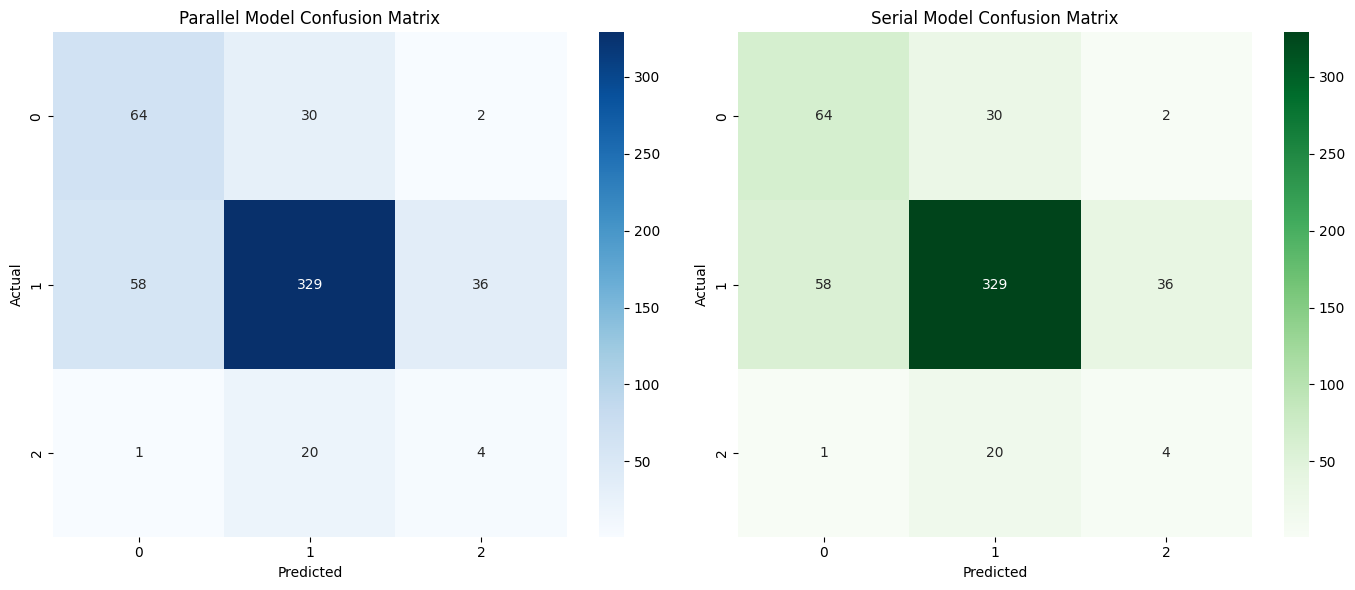

In [ ]:
# Confusion Matrix Visualization
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_parallel), annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Parallel Model Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

sns.heatmap(confusion_matrix(y_test, y_pred_serial), annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title('Serial Model Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

/tmp/ipython-input-16-495157492.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Severity', data=df, palette='Set2')


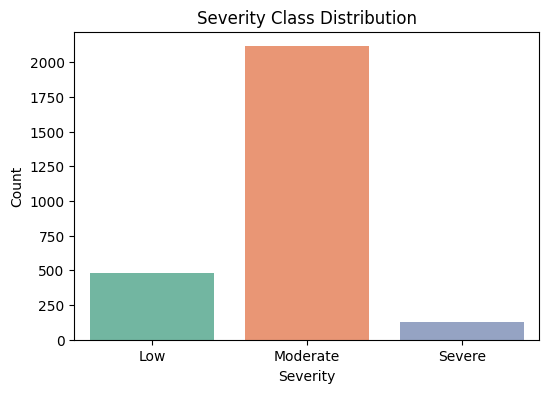

In [ ]:
# --- Class Balance ---
plt.figure(figsize=(6, 4))
sns.countplot(x='Severity', data=df, palette='Set2')
plt.title('Severity Class Distribution')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.show()

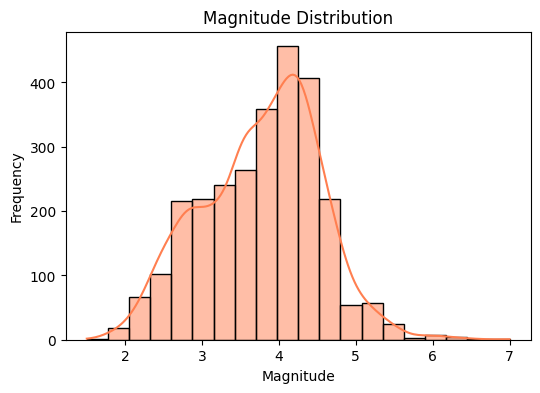

In [ ]:
# --- Magnitude Distribution ---
plt.figure(figsize=(6, 4))
sns.histplot(df['Magnitude'], bins=20, kde=True, color='coral')
plt.title('Magnitude Distribution')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.show()

/tmp/ipython-input-18-1185278471.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Severity', y='Depth', data=df, palette='coolwarm')


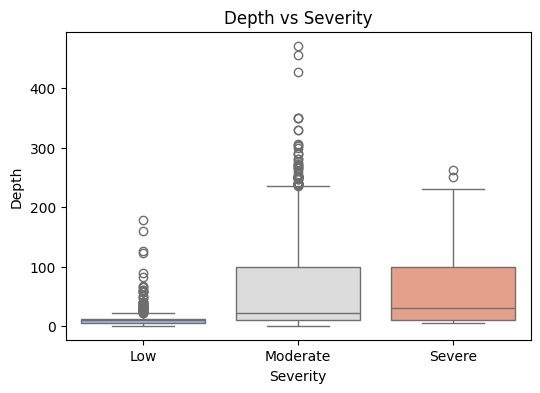

In [ ]:
# --- Depth Distribution ---
plt.figure(figsize=(6, 4))
sns.boxplot(x='Severity', y='Depth', data=df, palette='coolwarm')
plt.title('Depth vs Severity')
plt.show()

/tmp/ipython-input-19-27364428.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Hour', data=df, palette='viridis')


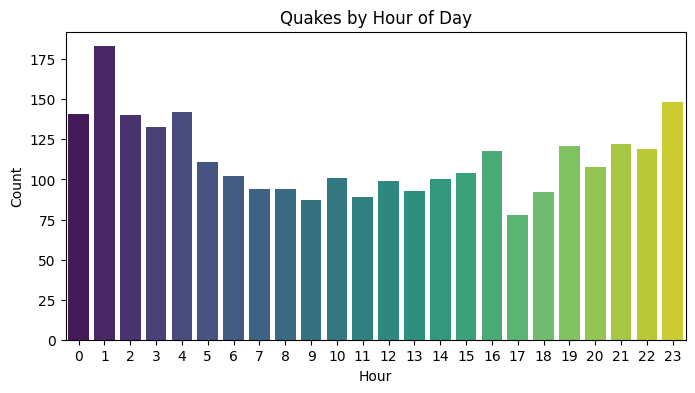

/tmp/ipython-input-19-27364428.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Day_of_Week', data=df, order=[


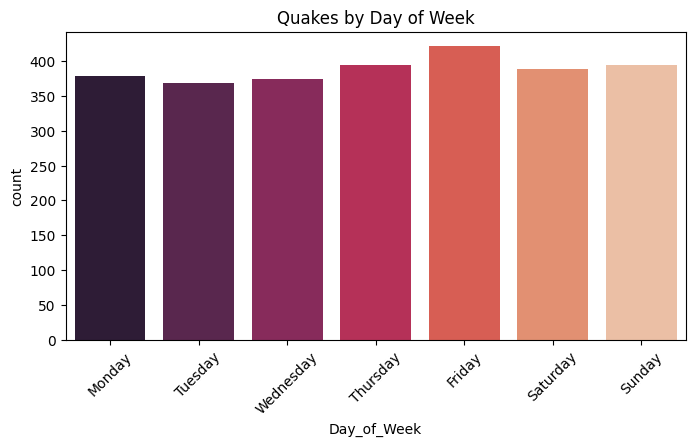

In [ ]:
# --- Time-based Patterns ---
plt.figure(figsize=(8, 4))
sns.countplot(x='Hour', data=df, palette='viridis')
plt.title('Quakes by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(x='Day_of_Week', data=df, order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    palette='rocket')
plt.title('Quakes by Day of Week')
plt.xticks(rotation=45)
plt.show()

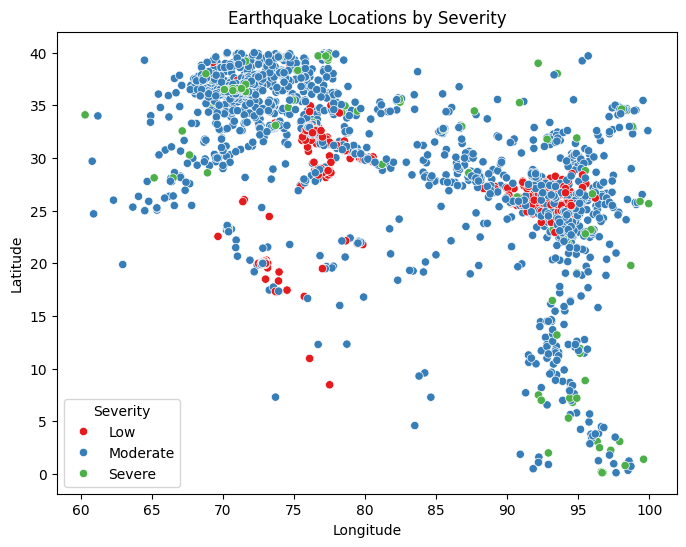

In [ ]:
# --- Geographical Distribution ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Longitude', y='Latitude', hue='Severity', data=df, palette='Set1')
plt.title('Earthquake Locations by Severity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Severity')
plt.show()

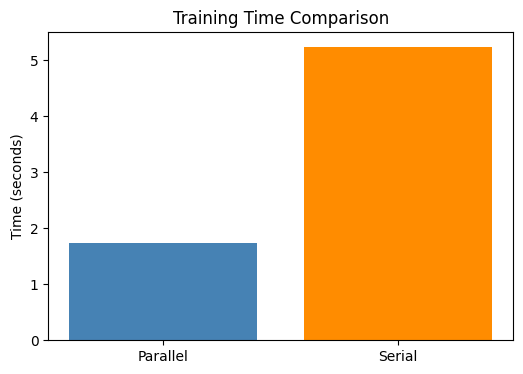

In [ ]:
import matplotlib.pyplot as plt

# Data
models = ['Parallel', 'Serial']
training_times = [1.736, 5.232]

plt.figure(figsize=(6, 4))
plt.bar(models, training_times, color=['steelblue', 'darkorange'])
plt.title('Training Time Comparison')
plt.ylabel('Time (seconds)')
plt.show()


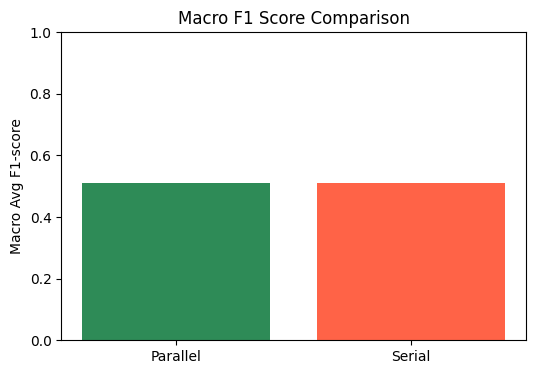

In [ ]:
macro_f1_scores = [0.51, 0.51]

plt.figure(figsize=(6, 4))
plt.bar(models, macro_f1_scores, color=['seagreen', 'tomato'])
plt.title('Macro F1 Score Comparison')
plt.ylabel('Macro Avg F1-score')
plt.ylim(0, 1)
plt.show()


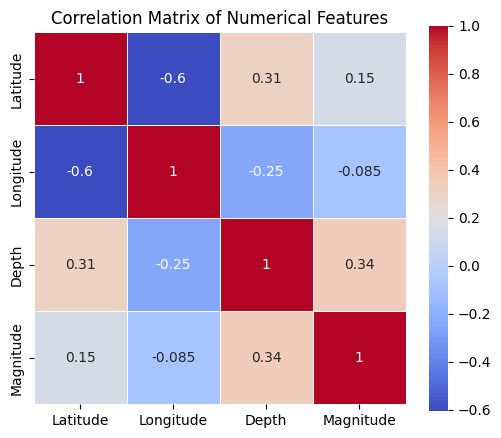

In [ ]:
# Select only numeric columns for correlation
numeric_features = ['Latitude', 'Longitude', 'Depth', 'Magnitude']
corr_matrix = df[numeric_features].corr()

# Plot correlation matrix
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, square=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

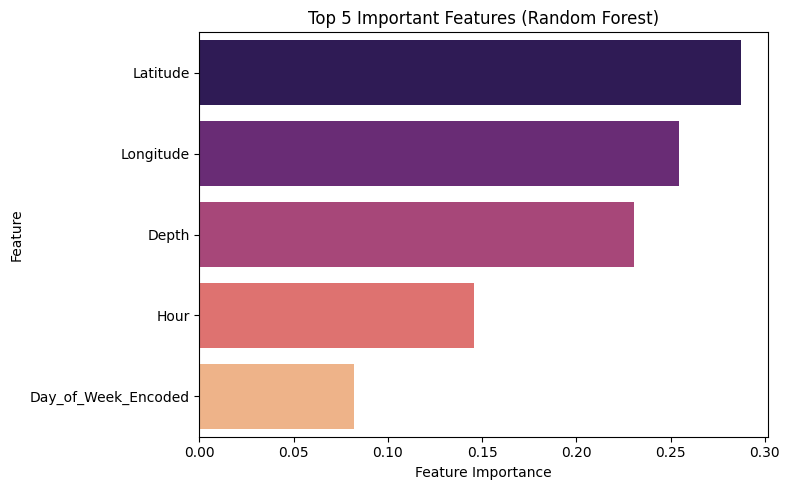

In [ ]:
feature_names = X_train.columns
importances = model_parallel.feature_importances_

# Create a DataFrame for easy sorting
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot top features
plt.figure(figsize=(8, 5))
sns.barplot(data=feat_df.head(10), x='Importance', y='Feature', hue='Feature', palette='magma', legend=False)
plt.title('Top 5 Important Features (Random Forest)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
# Assuming 'df' is the cleaned DataFrame you want to save
output_path = '/content/drive/MyDrive/cleaned_indian_earthquake_data.csv'
df.to_csv(output_path, index=False)
print(f"Cleaned data saved to {output_path}")

Cleaned data saved to /content/drive/MyDrive/cleaned_indian_earthquake_data.csv
